# Sentiment analysing RNN model 

## Main objective: compare both approaches for working with text data in Deep learning: RNN-based network and a 1D convnet. 
### Evaluation task: performing a binary sentiment analysis based on amazon customer reviews dataset from Kaggle. 
### Notable mentions: both networks will use pre-trained GloVe word embeddings (using a special particular version of GloVe that is created from Twitter users data)  

 I have decided to use the "Amazon Reviews for Sentiment Analysis" dataset variation I found on Kaggle: https://www.kaggle.com/bittlingmayer/amazonreviews/home. The variation is that I decided to use the data in the original format made by Xiang Zhang , instead of the FastText format provided in Kaggle. The original dataset consists of 1.47GB of training data (10800000 labelled train samples) and 167 MB of Test data (1200000 labelled test samples). Data is structured in the following way: 

| Sentiment |  Title  | Description|
|------|------|------|
|2|| Great CD || My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT|

#### 2 design decisions coming from the way the data in the dataset is structured: 

#### 1) 1-indexed labels: 
In the dataset "2" stands for "positive" and 1 for "negative" (i.e. the values are 1-indexed, not 0-index like normal booleans) This is a characteristic we will need to account for during our preprocessing stage. 

#### 2) two separate text columns in each review: 
Another important decision is how should we go about the fact that we have actually 2 columns with the text: the "title" and the "description" columns. I have decided to use the approach of concatenating both into one element during our preprocessing stage. This way, the title content is the first sentence in each of the reviews. This is something we should have in mind when we reach the stage of tokenizing, as we might want the title sentence (which is likely to capture the overal sentiment of the review most concisely) to be padded and tokenized in such a way it's the first in our 'review'. This piece of information might be especially useful for the RNN, as it is sensitive for the sequentiality of our review,thus, the most essential sentence in the front might make a difference

## Model 1:  Baseline RNN + word embedding layer model   

### Step 1: Initialising the raw-form train and test datasets 

#### Step 1.1.: loading our dataset into the project. 

As mentioned above, we are dealing with a much larger file than we have used on the labs and book examples. Therefore, I decided to rely on a popular data science package called **Pandas** to load my file in the CSV format. I have provided the pandas "read csv" method with the "sep" param for denoting that we want to delimit our pieces of data on the commas (as the CSV format stands for "comma-separated values file") and with the "names" param, where I specified each column's name, which we will use during the pre-processing stage.

In [1]:
# Step 1.1: initialise directory paths and load the amazon dataset 

import os
import pandas as pd

project_directory = 'C:\\Users\\greg\\Desktop\\My AI Repo'
# print (project_directory)
TEMPTestingfile = project_directory +"\\mytesting123.csv"  

amazon_dataset_dir = os.path.join(project_directory, 'Datasets\\amazon_review_polarity_csv')
# Step 1 load/process the data from the downloaded dataset. 
# NOTE: the right one:
amazon_train = pd.read_csv(f'{amazon_dataset_dir}\\train.csv',names=['sentiment', 'title','description'],sep=',')
amazon_test = pd.read_csv(f'{amazon_dataset_dir}\\test.csv',names=['sentiment', 'title','description'],sep=',')
# NOTE: testing file:
# amazon_train = pd.read_csv(TEMPTestingfile,  names=['sentiment', 'title','description'],sep=',')
# amazon_test = pd.read_csv(TEMPTestingfile,  names=['sentiment', 'title','description'],sep=',')


This process itself takes ~1.5 min and shows with how large data we deal with  

#### Step 1.2.:Creating a raw-text pre-processing function. 

Now, we need to store our loaded data in form of a list (array) for both the labels and the data of train and test datasets.
It is arguably the most tricky part of this coursework, therefore, let us explain it thoroughly.

##### a) Iterating through the loaded CSV  

"Pandas" provides a method "dataset_name.**iterrows()**". We will use this method to our advantage to iterate over all the rows in the dataset

##### b) Getting column values  

 We can obtain the values of each column by specifying row["name_of_column"] thanks to providing the parameter 'names' when loading the csv.

##### c) Correctly classifying the label 

As mentioned at the beginning of the document, due to how our dataset is structured, we need to correctly classify what is a 'positive' and a 'negative' review. To do that, I created a conditional which checks the value of the row["sentiment"] - if it's "1" it means it's a negative, thus we'll append 0 to our labels array. If it's "2" it's the otherwise.   

##### d) Defining the approach for how to treat 2 columns "title" and "description" 

As mentioned, I decided to use just concatenate the both columns to one big string. 

##### e) secureBlankData  

During my work I run into a rather hard-to-debug problem I haven't accounted for: missing values in the dataset. This issue took a lot of my work time, mainly due to a very vague error description in the stack trace saying "unable to concatenate 'float' with 'string' ". Indeed, blank values in the dataset (which happen to be 9 randomly missing title columns in the first 300000 rows) turned of out be parsed by Pandas as "NaN", which is a float data type, thus effectively preventing the code from string concatenation to the joined text value. 
I decided to fix that by creating a "secureBlankData" helper method that checks for any empty values and changes them to an empty string. 

##### f) Unbearable processing time:  

To my dismay, the pre-processing time of storing both datasets into lists took ~30 min each time. I decided to regulate the size of the datasets stored (and thus pre-processed) with a variable "restrictDataTo" which I set by default to 150000.

##### f) Unbalanced data

Finally, the trickiest problem. 
As I firstly encountered the dataset, I noticed that it was already randomly shuffled between 1s and 2s. I believed it to be a good thing only then realising that if we restrict the data stored, we will end up with unbalanced distribution of '1' and '0' labelled data. This is because the data in the dataset is randomly distributed. Therefore, despite there is an even distribution of '1' and '0' labelled data in overall, if we decided to take only a portion of the data, we might end up with not perfectly split data. 

As a solution to that problem, I created a series of conditionals that store the data in such a manner that omits some of the reviews if in that particular moment there's already more of them than the opposite-labelled ones. This way, with the cost of ommiting some of the reviews (which shouldn't be a big problem, since we decided to take a feasible portion of them anyway) , we can create an evenly-distributed dataset of positive and negative labels for both the train and the test set.   

In [2]:
# Step 1.2: Create a pre-process function and the helper "secureBlankData" function 
def preprocessText(dataset, whichVariant:int = 1, restrictDataTo:int = 150000,trainOrTest:str = ''):
    """This function preprocess the data into train/test_labels and train/test_data. NOTE: @param whichVariant lets you choose 2 possible variants of the algo. 1 is the (default) variant which saves both the title and description as one big string chunk in the train data. 2 is for ...(TODO) """
    # restrictDataTo = restrictDataTo -1 #We're taking into account that array is 0-indexed. 
    _labels = []
    _data = []
    _zero_labels = 0 
    _one_labels = 0 
    _equal_half = int(restrictDataTo//2)

    for row_index,row in dataset.iterrows():
                
        # NOTE: labels in our dataset are "1" for negative and "2" for positive (i.e. they're not 0-indexed but 1-indexed)
        if row["sentiment"] == 1:
            if _zero_labels > _one_labels:
                continue
            _labels.append(0)
            _zero_labels += 1
        else: # i.e. if row["sentiment"] == 2
            if _one_labels > _zero_labels:
                continue
            _labels.append(1)
            _one_labels += 1
        
        if whichVariant == 1:
            # NOTE: this " " is soo important for our corect word tokenizaton.
            title = row["title"] 
            title = secureBlankData(title)
            description =  row["description"]
            description = secureBlankData(description)
            text = title + " " + description
            _data.append(text)
        else:
            # FIXME: Test me !! Might have problems with bigger dimensionality, check it !!!
            # FIXME: there are problems with wrong tokenization of the data with this variant so far!!
            content = [row["title"], row["description"]]
            _data.append(content)

        if row_index >= restrictDataTo and _zero_labels == _one_labels and _zero_labels>=restrictDataTo/2 and  _one_labels>=restrictDataTo/2:
            break

    print(f"Finished pre-processing {trainOrTest} data")
    print(f"Number of negative-labelled data: {_zero_labels}")
    print(f"Number of positive-labelled data: {_one_labels}")
    return _labels, _data

def secureBlankData(data):
    """This function is for ensuring that if we ever loop over an empty data (e.g. no text in the title column) then we will safely change the NaN type of this data to just an empty string"""
    if type(data) != str:
        return ''
    return data

#### Step 1.3.:Calling the function. 

Finally, we can call this custom function for both the train and the test datasets.

In [3]:
# Step 1.3: store the pre-processed un-tokenized train/test data/labels.
labels, train_data = preprocessText(amazon_train,trainOrTest='train', restrictDataTo= 150000) 
test_labels, test_data = preprocessText(amazon_test,trainOrTest='test', restrictDataTo= 50000)

Finished pre-processing train data
Number of negative-labelled data: 75000
Number of positive-labelled data: 75000
Finished pre-processing test data
Number of negative-labelled data: 25000
Number of positive-labelled data: 25000


### Step 2.:Tokenizing the data. 

"Like all other neural networks, deep-learning models don’t take as input raw text:
they only work with numeric tensors. Vectorizing text is the process of transforming text
into numeric tensors[...] Collectively, the different units into which you can break down text (words, charac-
ters, or n-grams) are called tokens, and breaking text into such tokens is called tokeniza-
tion." (F.Chollet, "Deep Learning With Python")

Just like mentioned in the DLWP, we need to tokenise the data we have pre-processed and stored in our raw-version lists. To do that, I will use  the keras preprocessing Tokenizer class

The following piece of code rather similar to what has been provided in the "DLWP Notebook master" in section "6.1-using-word-embeddings". I slightly modified the code and decided to use a bigger maxlen and max_words since I have a greatly bigger set of data to choose from. Notice also my hold out validation approach: because the way I created my processing, I was able to make an evenly-labelled dataset ( "1-0-1-0 reviews etc."), therefore, my hold-out validation is balanced as well. Also, the size of my training data is sufficiently large to use 25% of it as my validation.     

In [4]:
# Step 2: Tokenize the data:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150  # We will cut reviews after 150 words

max_words = 20000  # We will only consider the top 20,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

print("========= Train labels ============")
labels = np.asarray(labels)
print(labels)
# TODO: Here you should check if the distribution of the 0 & 1 labels is even !!
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# NOTE: I use a simple hold-out validation. This is because I have plenty of data and the data is already shuffled in the dataset. 
training_samples = int(len(labels)//1.25)  
validation_samples = len(labels) - training_samples 

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 161900 unique tokens.
========= Train labels ============
[1 0 1 ... 1 1 0]
Shape of data tensor: (150000, 150)
Shape of label tensor: (150000,)


### Step 3.:Preparing the GloVe word embedding 

The next step is to load the GloVe embedding and save it in our dictionary "embeddings_index". The embeddings_index after the preparation will consists of the string as a key in this dictionary (e.g. "super") and an N number of dimensions associated with this word in form of a float32 value (e.g. "0.23194" etc.) where N is the GloVe version we chose to work with. Each GloVe version has a "XXd" number in it's filename denoting how many dimensions are associated with words in the given GloVe version. 

I also decided to work with a specific GloVe version created through web scraping Twitter data tweets instead of the one using English dictionary or Wikipedia, as I believe it would be more related to the language amazon's customer reviews typically are made in 

In [5]:
# Step 3: load the GloVe dataset for word embeddings
glove_dir = project_directory + "\\Datasets\\glove.twitter.27B"

embeddings_index = {}
# NOTE: I have 4 versions of GloVe on my machine, each different in size (and the number of words associated): 
# - glove.6B.25d.txt has .25GB size   
# - glove.6B.50d.txt has .5GB size   
# - glove.6B.100d.txt has 1GB size   
# - glove.6B.200d.txt has 2GB size   
whichGloveVersion = 25
gloveFile = f"glove.twitter.27B.{whichGloveVersion}d.txt"
with open(os.path.join(glove_dir, gloveFile),'r',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


### Step 4.:create the embedding matrix from the GloVe dictionary

This is a code for making an embedding matrix out of the GloVe dictionary we created in the previous step. I used the same code from the section "6.1-using-word-embeddings" from DLWP.  

In [6]:
# Step 4: pre-process the GloVe
# NOTE: embedding_dim needs to be set exactly to the number matching the "whichGloveVersion". 
# This is because the GloVe version defines how big is the dimensionality of each word in the given GloVe txt file.
embedding_dim = 25

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Step 5.: defining the RNN model


I decided to use LSTM as my RNN model. I will rely on Keras' default hyper-parameters as this is a baseline model.

In [10]:
# Step 5: Define a model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 25)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                7424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 507,457
Trainable params: 507,457
Non-trainable params: 0
_________________________________________________________________


### Step 6.: Freezing the weights of the embedding layer 

As we would like to use the weights trained by the GloVe network in our model, we need to set them at the embedding layer and also make them non-trainable ("freeze" them), otherwise the weights of the layer would be overriden with random values during the first epoch and so the whole point of using the GloVe network.   

In [11]:
# Step 6: "Freeze" the weights on our pre-trained GloVe network.
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Step 7.: Compiling the model 

Finally, we can compile the model and see the first results!

In [12]:
# Step 7: Compile the model 
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val,y_val))

Train on 120000 samples, validate on 30000 samples
Epoch 1/10
120000/120000 [==============================] - 210s 2ms/step - loss: 0.6535 - acc: 0.6114 - val_loss: 0.6856 - val_acc: 0.5294
Epoch 2/10
120000/120000 [==============================] - 233s 2ms/step - loss: 0.5845 - acc: 0.6991 - val_loss: 0.6456 - val_acc: 0.6747
Epoch 3/10
120000/120000 [==============================] - 264s 2ms/step - loss: 0.4638 - acc: 0.7886 - val_loss: 0.4129 - val_acc: 0.8196
Epoch 4/10
120000/120000 [==============================] - 263s 2ms/step - loss: 0.4140 - acc: 0.8178 - val_loss: 0.4119 - val_acc: 0.8246
Epoch 5/10
120000/120000 [==============================] - 266s 2ms/step - loss: 0.3896 - acc: 0.8300 - val_loss: 0.3688 - val_acc: 0.8419
Epoch 6/10
120000/120000 [==============================] - 259s 2ms/step - loss: 0.3689 - acc: 0.8405 - val_loss: 0.3483 - val_acc: 0.8494
Epoch 7/10
120000/120000 [==============================] - 260s 2ms/step - loss: 0.3529 - acc: 0.8484 - val_

In [11]:
# This is my own source code which I used in the first coursework. 
import matplotlib.pyplot as plt
def plotFunc(isLossPlot, epochsNum, train_LossOrAcc, val_LossOrAcc):
    """Plots either a train & val loss (when isLossPlot is True) or the accuracy"""
    plt.clf() #Clear any previous plot
    if isLossPlot: 
        label1 = 'Training loss'
        label2 = 'Validation loss'
    else: 
        label1 = 'Training accuracy'
        label2 = 'Validation accuracy'
    plt.plot(epochsNum, train_LossOrAcc, 'bo', label =label1)
    plt.plot(epochsNum, val_LossOrAcc, 'b', label = label2)  
    plt.xlabel('Epochs')
    # We repeat the condition to correctly name the ylabel. 
    # NB. We could avoid repeating the conditional by just extracting/slicing the second word from the label 1 or 2 
    # but for an increased readability I left it this way. 
    if isLossPlot:
        plt.title("Training and validation loss")
        plt.ylabel('Loss')
    else: 
        plt.title("Training and validation accuracy")
        plt.ylabel('Accuracy')
    plt.legend()

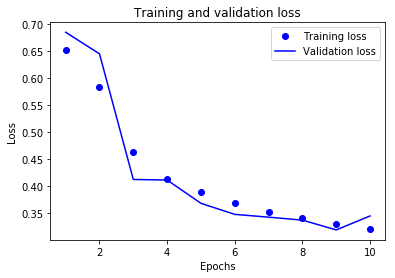

In [16]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plotFunc( True,epochs, loss, val_loss)

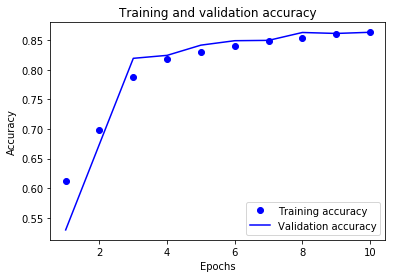

In [17]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plotFunc(False, epochs, acc, val_acc)

## The result

The model performed very well given being a baseline network with default parameters, however, it is very important to notice one phenomenon: it took  **42 min and 33s** to train it! Let us see how the 1D compares to that level. 

## 1D Convnet-based baseline model: 

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model2 = Sequential()
model2.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(32, 5, activation='relu', padding='same'))
model2.add(layers.MaxPooling1D(5))
model2.add(layers.Conv1D(32, 5, activation='relu', padding='same'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 25)           500000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 32)           4032      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 32)            5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 509,217
Trainable params: 509,217
Non-trainable params: 0
_________________________________________________________________


In [8]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [9]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val,y_val))

Train on 120000 samples, validate on 30000 samples
Epoch 1/10
120000/120000 [==============================] - 52s 433us/step - loss: 0.4945 - acc: 0.7536 - val_loss: 0.4086 - val_acc: 0.8130
Epoch 2/10
120000/120000 [==============================] - 53s 439us/step - loss: 0.3918 - acc: 0.8228 - val_loss: 0.3615 - val_acc: 0.8417
Epoch 3/10
120000/120000 [==============================] - 53s 443us/step - loss: 0.3650 - acc: 0.8386 - val_loss: 0.3696 - val_acc: 0.8364
Epoch 4/10
120000/120000 [==============================] - 55s 459us/step - loss: 0.3487 - acc: 0.8467 - val_loss: 0.3692 - val_acc: 0.8352
Epoch 5/10
120000/120000 [==============================] - 52s 435us/step - loss: 0.3377 - acc: 0.8538 - val_loss: 0.3419 - val_acc: 0.8516
Epoch 6/10
120000/120000 [==============================] - 53s 439us/step - loss: 0.3279 - acc: 0.8579 - val_loss: 0.3878 - val_acc: 0.8298
Epoch 7/10
120000/120000 [==============================] - 53s 443us/step - loss: 0.3208 - acc: 0.8613

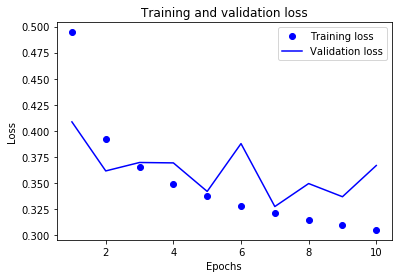

In [12]:
history_dict = history2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plotFunc( True,epochs, loss, val_loss)

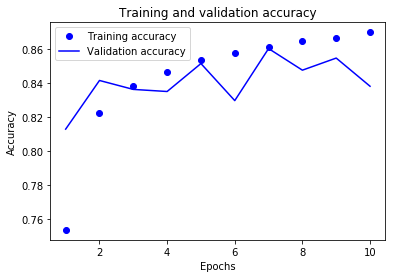

In [13]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plotFunc(False, epochs, acc, val_acc)

# First conclusion: 1D convnets take 5x less time! 

While it might be arguable whether the baseline Convnet achieved more or less same score (we can see RNN had much more stable results, nonetheless achieving nearly the same high score), one observation is striking: training this convnet took **9  min 44s**, it's around 33mins quicker and nearly a fifth of time necessary to train our RNN. 
Therefore, due to lack of computational resources I must put a verdict: 

## For my specific task (and given my hardware level) the 1D convnet is a winner even by comparing just the baseline versions of the models. 

# Further optimisation of the Convnet

As the last part of this experiment, given the preffered structure is already chosen, I will try to tweak the baseline model

#### Removing the same padding

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model2 = Sequential()
model2.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(32, 5, activation='relu'))
model2.add(layers.MaxPooling1D(5))
model2.add(layers.Conv1D(32, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 25)           500000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 146, 32)           4032      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 25, 32)            5152      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 509,217
Trainable params: 509,217
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val,y_val),
                    verbose=1)

Train on 120000 samples, validate on 30000 samples
Epoch 1/10
120000/120000 [==============================] - 48s 398us/step - loss: 0.5646 - acc: 0.7014 - val_loss: 0.4972 - val_acc: 0.7608
Epoch 2/10
120000/120000 [==============================] - 49s 406us/step - loss: 0.4620 - acc: 0.7815 - val_loss: 0.4401 - val_acc: 0.7927
Epoch 3/10
120000/120000 [==============================] - 47s 392us/step - loss: 0.4242 - acc: 0.8047 - val_loss: 0.4789 - val_acc: 0.7742
Epoch 4/10
120000/120000 [==============================] - 48s 399us/step - loss: 0.4011 - acc: 0.8178 - val_loss: 0.4250 - val_acc: 0.8064
Epoch 5/10
120000/120000 [==============================] - 50s 416us/step - loss: 0.3854 - acc: 0.8267 - val_loss: 0.4618 - val_acc: 0.7869
Epoch 6/10
120000/120000 [==============================] - 49s 410us/step - loss: 0.3760 - acc: 0.8323 - val_loss: 0.4112 - val_acc: 0.8133
Epoch 7/10
120000/120000 [==============================] - 49s 411us/step - loss: 0.3653 - acc: 0.8383

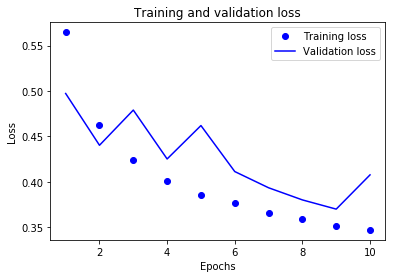

In [23]:
history_dict = history2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plotFunc( True,epochs, loss, val_loss)

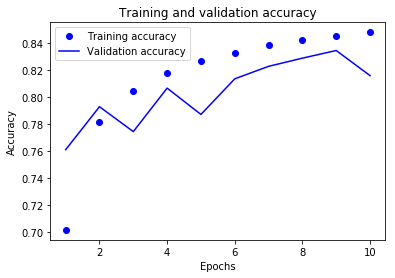

In [24]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plotFunc(False, epochs, acc, val_acc)

#### Adding regularization + dropout and increasing the number of epochs 

In [31]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import regularizers

model2 = Sequential()
model2.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(32, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.02)))
model2.add(layers.MaxPooling1D(5))
# model2.add(layers.Dropout(0.2))
model2.add(layers.Conv1D(32, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.02)))
model2.add(layers.GlobalMaxPooling1D())
# model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 150, 25)           500000    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 150, 32)           4032      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 30, 32)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 30, 32)            5152      
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 509,217
Trainable params: 9,217
Non-trainable params: 500,000
_________________________________________________________________


In [32]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val,y_val),
                    verbose=1)

Train on 120000 samples, validate on 30000 samples
Epoch 1/10
120000/120000 [==============================] - 52s 432us/step - loss: 0.7321 - acc: 0.7234 - val_loss: 0.5827 - val_acc: 0.7990
Epoch 2/10
120000/120000 [==============================] - 51s 426us/step - loss: 0.5911 - acc: 0.7850 - val_loss: 0.5814 - val_acc: 0.7878
Epoch 3/10
120000/120000 [==============================] - 54s 454us/step - loss: 0.5797 - acc: 0.7933 - val_loss: 0.5604 - val_acc: 0.8137
Epoch 4/10
120000/120000 [==============================] - 53s 438us/step - loss: 0.5754 - acc: 0.7966 - val_loss: 0.5599 - val_acc: 0.8087
Epoch 5/10
120000/120000 [==============================] - 53s 442us/step - loss: 0.5735 - acc: 0.7979 - val_loss: 0.6119 - val_acc: 0.7612
Epoch 6/10
120000/120000 [==============================] - 53s 443us/step - loss: 0.5721 - acc: 0.7981 - val_loss: 0.5608 - val_acc: 0.8065
Epoch 7/10
120000/120000 [==============================] - 52s 437us/step - loss: 0.5714 - acc: 0.7991

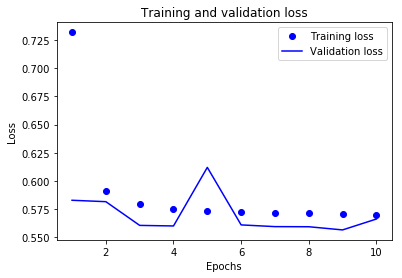

In [33]:
history_dict = history2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plotFunc( True,epochs, loss, val_loss)

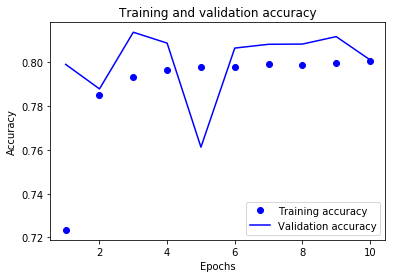

In [34]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plotFunc(False, epochs, acc, val_acc)

Final version of the model

In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import regularizers

model2 = Sequential()
model2.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(32, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model2.add(layers.MaxPooling1D(5))
model2.add(layers.Dropout(0.1))
model2.add(layers.Conv1D(32, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dropout(0.1))
model2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 150, 25)           500000    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 150, 32)           4032      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 30, 32)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 30, 32)            5152      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

In [39]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(x_train, y_train,
                    epochs=9,
                    batch_size=128,
                    validation_data=(x_val,y_val),
                    verbose=1)

Train on 120000 samples, validate on 30000 samples
Epoch 1/9
120000/120000 [==============================] - 58s 485us/step - loss: 0.6924 - acc: 0.7318 - val_loss: 0.5494 - val_acc: 0.7964
Epoch 2/9
120000/120000 [==============================] - 56s 471us/step - loss: 0.5509 - acc: 0.7925 - val_loss: 0.5623 - val_acc: 0.7730
Epoch 3/9
120000/120000 [==============================] - 58s 481us/step - loss: 0.5430 - acc: 0.7977 - val_loss: 0.5180 - val_acc: 0.8137
Epoch 4/9
120000/120000 [==============================] - 57s 471us/step - loss: 0.5398 - acc: 0.7974 - val_loss: 0.5146 - val_acc: 0.8166
Epoch 5/9
120000/120000 [==============================] - 57s 476us/step - loss: 0.5371 - acc: 0.8005 - val_loss: 0.5113 - val_acc: 0.8199
Epoch 6/9
120000/120000 [==============================] - 57s 473us/step - loss: 0.5363 - acc: 0.8012 - val_loss: 0.5183 - val_acc: 0.8150
Epoch 7/9
120000/120000 [==============================] - 57s 474us/step - loss: 0.5363 - acc: 0.8006 - val_

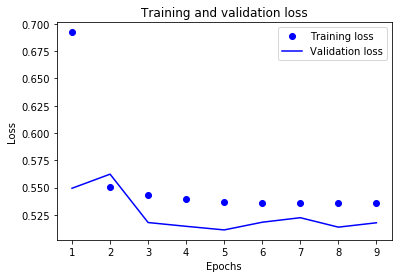

In [40]:
history_dict = history2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plotFunc( True,epochs, loss, val_loss)

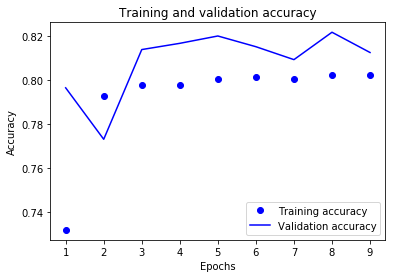

In [41]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plotFunc(False, epochs, acc, val_acc)

### Running the neutwork on the test set.  

Let's tokenise the test data to run the final evaluation. 

In [37]:
test_sequences = tokenizer.texts_to_sequences(test_data)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [42]:
results = model2.evaluate(x_test, y_test)

ValueError: Input arrays should have the same number of samples as target arrays. Found 50000 input samples and 150000 target samples.

### Acknowledgement: I was not able to make the model to evaluate on the test data. 

# Conclusions: 

### 1. The 1D convolutional network appears to have slightly worse results than the baseline RNN network, however it took almost 5X less time to train during the experiments.  

### 2. The majority of time in the experiment was taken to ensure the data is properly loaded and split into evenly-label portions.

### 3. This experiment is notably less in-depth in terms of the network trainings, mainly due to putting the pressure on acquiring outside-world data (I used the built-in IMDB dataset in the previous coursework) and correctly pre-processing it to fit our project.

# Extra notes: 

This experiment is much less thorough as I would like it to be, mainly due to the Tensorflow 1D convolutional network issue I struck upon and needed to solve, which is also explained in this thread:  https://github.com/tensorflow/tensorflow/issues/17945 

# Bibliography:

[1] Manning Publications, 2017, Chollet F., "Deep Learning with Python"